In [90]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

# display(interactions_df[interactions_df.isna().any(axis=1)])

# drop rows with NaN value
interactions_df.dropna(inplace=True)
display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[0-160],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[160-260],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[160-260],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [126]:
def n_to_p(l):
    n = sum(l)
    return [x / n for x in l] if n > 0 else l

def calculate_p(x, values):
    counts = [0]*len(values)
    for v in x:
        counts[values.index(v)] += 1

    return n_to_p(counts)


def prepare_users_df(interactions_df):

    users_df = interactions_df.loc[:, ["user_id"]]
    users_df = users_df.groupby("user_id").first().reset_index(drop=False)
    
    user_features = []

    for column in base_item_features:

        column_values = column_values_dict[column]
        df = interactions_df.loc[:, ['user_id', column]]
        df = df.groupby('user_id').aggregate(lambda x: list(x)).reset_index(drop=False)

        df.loc[:, column] = df[column].apply(lambda x: calculate_p(x, column_values))

        p_columns = []
        for i in range(len(column_values)):
            p_columns.append("user_" + column + "_" + column_values[i])
            df.loc[:, p_columns[i]] = df[column].apply(lambda x: x[i])
            user_features.append(p_columns[i])

        users_df = pd.merge(users_df, df.loc[:, ['user_id'] + p_columns], on=["user_id"])
    
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,0.090909,0.0,0.681818,0.090909,0.136364,0.000000,0.000000,0.0,0.000000,0.590909,0.409091,0.000000,0.500000,0.500000,0.727273,0.136364,0.045455,0.045455,0.045455,0.000000,0.727273,0.181818,0.090909,0.772727,0.227273
40,50,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.0,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.217391,0.260870,0.304348,0.217391,0.000000,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
84,96,0.090909,0.0,0.681818,0.136364,0.045455,0.045455,0.000000,0.0,0.272727,0.636364,0.045455,0.045455,0.272727,0.727273,0.636364,0.227273,0.090909,0.045455,0.000000,0.045455,0.272727,0.590909,0.090909,0.727273,0.272727
102,115,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,1.000000
370,706,0.098765,0.0,0.518519,0.185185,0.135802,0.049383,0.012346,0.0,0.283951,0.395062,0.234568,0.086420,0.975309,0.024691,0.592593,0.308642,0.049383,0.049383,0.000000,0.123457,0.160494,0.580247,0.135802,0.592593,0.407407
1381,1736,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.0,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.310345,0.517241,0.137931,0.034483,0.000000,0.379310,0.413793,0.206897,0.000000,0.448276,0.551724
7283,7779,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.250000,0.500000,0.250000,1.000000,0.000000,0.250000,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.750000,0.250000,0.750000,0.250000


In [110]:
### ONE HOT ENCODING ###

def prepare_interactions_df(interactions_df):
    interactions_df_copy = interactions_df.copy()
    interactions_df_copy.drop_duplicates(subset="user_id", inplace=True)
    interactions_df_copy.drop('item_id', inplace=True, axis=1)
    
    return interactions_df_copy

def prepare_users_df_one_hot(interactions_df):
    interactions_df_copy = prepare_interactions_df(interactions_df)
    
    column_names = list(interactions_df_copy.columns[1:])
    users_df = pd.get_dummies(
        data=interactions_df_copy,
        columns=column_names
    )
    user_features = list(users_df.columns)
    
    return users_df, user_features
    
    
users_df, user_features = prepare_users_df_one_hot(interactions_df)

print(user_features)
display(users_df)

['user_id', 'term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


,user_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,length_of_stay_bucket_[0-1],...,room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[1-1],n_people_bucket_[2-2],n_people_bucket_[3-4],n_people_bucket_[5-inf],weekend_stay_True,weekend_stay_False
0,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,2,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
2,3,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15262,14245,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
15263,14315,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
15264,14364,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
15266,14454,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [158]:
### AVERAGE BUCKETING ###

length_of_stay_avg = {
    '[0-1]': 0.5, '[2-3]': 2.5,'[4-7]': 5.5,'[8-inf]': 9
}

room_segment_avg = {
    '[0-160]': 80, '[160-260]': 210,'[260-360]': 310,'[360-500]': 430,'[500-900]': 700  
}

n_people_avg = {
    '[1-1]': 1, '[2-2]': 2,'[3-4]': 3.5,'[5-inf]': 5  
}

def prepare_users_df_bucketing(interactions_df):
    interactions_df_copy = interactions_df.copy()
    
    users_df = pd.DataFrame(dtype=float)
    users_df = interactions_df_copy.loc[:, ["user_id", "length_of_stay_bucket", "room_segment", "n_people_bucket"]]
    # without astype(float) -> data type of column is category and it's impossible to use aggregate funcions
    users_df.loc[:, 'length_of_stay_bucket'] = users_df['length_of_stay_bucket'].map(length_of_stay_avg).astype(float)
    users_df.loc[:, 'room_segment'] = users_df['room_segment'].map(room_segment_avg).astype(float)
    users_df.loc[:, 'n_people_bucket'] = users_df['n_people_bucket'].map(n_people_avg).astype(float)
    
    users_df = users_df.groupby('user_id').mean().reset_index()
    user_features = list(users_df.columns)
    
    return users_df, user_features
    
users_df, user_features = prepare_users_df_bucketing(interactions_df)

print(user_features)
display(users_df)


['user_id', 'length_of_stay_bucket', 'room_segment', 'n_people_bucket']


,user_id,length_of_stay_bucket,room_segment,n_people_bucket
0,1,3.727273,152.272727,2.545455
1,2,2.500000,210.000000,3.500000
2,3,2.500000,210.000000,2.000000
3,4,5.500000,80.000000,3.500000
4,5,5.500000,80.000000,2.000000
...,...,...,...,...
13768,14498,2.500000,210.000000,1.000000
13769,14499,9.000000,80.000000,2.000000
13770,14500,2.500000,210.000000,3.500000
13771,14501,2.500000,80.000000,3.500000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [4]:
def map_items_to_onehot(df):
    one_hot = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis = 1)
    df = df.join(one_hot)
    
    return df, list(one_hot.columns)

def prepare_items_df(interactions_df):
    items_df = interactions_df.loc[:, ["item_id"] + base_item_features].drop_duplicates()
    
    items_df, item_features = map_items_to_onehot(items_df)
    
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


,item_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,length_of_stay_bucket_[0-1],length_of_stay_bucket_[2-3],length_of_stay_bucket_[4-7],length_of_stay_bucket_[8-inf],rate_plan_Standard,rate_plan_Nonref,room_segment_[0-160],room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[1-1],n_people_bucket_[2-2],n_people_bucket_[3-4],n_people_bucket_[5-inf],weekend_stay_True,weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0


In [5]:
### PLAYGROUND ###
display(len(users_df.columns))
display(len(user_features))

#torch.cuda.is_available()
#torch.cuda.device_count()
#torch.cuda.current_device()
#torch.cuda.device(0)
torch.cuda.get_device_name(0)

26

25

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [72]:
###### MODELS ######

### Two Layer Model ###
class TwoLayerModel(nn.Module):
    def __init__(self, in_neurons, hidden_neurons, seed):
        """
        :param int in_neurons: Number of in neurons.
        :param int hidden_neurons: Number of neurons in first hidden layer.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        self.seed = torch.manual_seed(seed)

        hidden_neurons_2 = int(hidden_neurons / 2)
        
        self.fc1 = nn.Linear(in_neurons, hidden_neurons, bias=False)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons_2, bias=False)
        self.fc3 = nn.Linear(hidden_neurons_2, 1, bias=False)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    

### GMF Model ###
class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        self.seed = torch.manual_seed(seed)
        
        # display("n_items: ", n_items)
        # display("n_users: ", n_users)
        
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1, bias=False)


    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        # display("user_ids: ", len(user_ids))
        # display("item_ids: ", len(item_ids))
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = self.fc(user_embedding * item_embedding)
        x = torch.sigmoid(x)

        return x
    
    
### MLP Model ###
class MLPModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int hidden_dim: Dimension of the first hidden layer.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        hidden_dim_lay_2 = int(hidden_dim / 2)
        
        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_lay_2, bias=True)
        self.fc3 = nn.Linear(hidden_dim_lay_2, 1, bias=False)


    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        x = torch.cat([self.user_embedding(user_ids), self.item_embedding(item_ids)], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x
    
### NeuMFModel ###
class NeuMFModel(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int hidden_dim: Dimension of the first hidden layer of the MLP part of the network.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()
        
        mlp_hidden_lay_2 = int(hidden_dim / 2)

        self.seed = torch.manual_seed(seed)
        
        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)
        
        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.fc1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, mlp_hidden_lay_2, bias=True)

        self.fc_merge = nn.Linear(mlp_hidden_lay_2 + gmf_embedding_dim, 1, bias=False)
        

    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        
        gmf_user_embedding = self.gmf_user_embedding(user_ids)
        gmf_item_embedding = self.gmf_item_embedding(item_ids)
        gmf_x = gmf_user_embedding * gmf_item_embedding
        
        mlp_user_embedding = self.mlp_user_embedding(user_ids)
        mlp_item_embedding = self.mlp_item_embedding(item_ids)
        mlp_x = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_x = torch.relu(self.fc1(mlp_x))
        mlp_x = torch.relu(self.fc2(mlp_x))
        
        x = torch.cat([gmf_x, mlp_x], dim=1)
        x = torch.sigmoid(self.fc_merge(x))

        return x

In [73]:
def rand_negative_interactions(interactions_df, rng, negative_interactions_size):
    negative_interactions = []
    
    max_user = interactions_df['user_id'].max()
    max_item = interactions_df['item_id'].max()

    # print(max_user, max_item)
    
    positive_interactions = interactions_df[['user_id', 'item_id']].to_numpy()
    
    while (len(negative_interactions) < negative_interactions_size):
        user_id = rng.choice(max_user + 1)
        item_id = rng.choice(max_item + 1)
        
        negative_interaction = tuple((user_id, item_id))
        
        if not (negative_interaction == positive_interactions).all(axis=1).any():
            negative_interactions.append(tuple((user_id, item_id, 0)))

            
    return negative_interactions

In [75]:
from recommenders.recommender import Recommender
from collections import deque

class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(
            self, seed=6789, n_neg_per_pos=7, device='cuda:0', 
            lr=0.001, weight_decay=0.0001, n_epochs=10, embedding_dim=4,
            batch_size=32, print_train=False, model_to_use="MLPModel", optimizer_to_use="Adam"
        ):
        """
        Initialize recommender params and variables.
        """
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.r = None
        self.most_popular_items = None
        
        self.model = None
        self.model_to_use = model_to_use
        self.optimizer = None
        self.optimizer_to_use = optimizer_to_use
        self.device = torch.device(device)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        self.validation_set_size = 0.2
        
        self.n_epochs = int(n_epochs)
        self.n_neg_per_pos = int(n_neg_per_pos)
        self.lr = lr
        self.weight_decay = weight_decay
        self.embedding_dim = int(embedding_dim)
        self.hidden_dim = (4 if embedding_dim is None else int(embedding_dim / 2))
        self.batch_size = int(batch_size)
        
        self.print_train = print_train
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        interactions_df = interactions_df.copy()
        
        del users_df, items_df

        # Shift item ids and user ids so that they are consecutive
        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)
        
        # Get the number of items and users
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1
        
        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        # r = np.zeros(shape=(n_users, n_items))
        # for idx, interaction in interactions_df.iterrows():
        #    r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        # self.r = r
        
        # Indicate positive interactions
        
        interactions_df.loc[:, 'interacted'] = 1
        
        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        # users_df, user_features = prepare_users_df(interactions_df)
        
        # self.users_df = users_df
        # self.user_features = user_features
        
        # items_df, item_features = prepare_items_df(interactions_df)
        # items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Generate negative interactions
        neg_inter_size = int(len(interactions_df) * self.n_neg_per_pos)
        negative_interactions = rand_negative_interactions(interactions_df, self.rng, neg_inter_size)
                
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        #interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        #interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])
        
        # Initialize the neural network model
        # num_columns = len(user_features)
        # n_items = len(items_df.index)
        # n_users = len(users_df.index)
        # display(n_items, n_users)
        
        # Choose model
        if self.model_to_use == "GMFModel":
            self.model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
        elif self.model_to_use == "NeuMFModel":
            self.model = NeuMFModel(
                n_items, n_users, self.embedding_dim, self.embedding_dim, self.hidden_dim, self.seed
            )
        else:
            self.model = MLPModel(n_items, n_users, self.embedding_dim, self.hidden_dim, self.seed)
            
        self.model.train()
        self.model.to(self.device)
        
        # Choose optimizer
        if self.optimizer_to_use == "SGD":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        liveloss = PlotLosses()
        
        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        last_training_total_loss = 0.0
        
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_validation_total_loss = 0.0
        
        interaction_ids = self.rng.permutation(len(interactions_df))
        train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]
        
        # Train the model using an optimizer
        for epoch in range(self.n_epochs):
            logs = {}
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                # display(n_batches)
                # display(self.batch_size)
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                # display(batch_ids)
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses
                y = self.model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate
                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                if self.print_train:
                    print("\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}".format(
                            epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
                
                
            # Save and print epoch losses
            training_last_avg_loss = training_total_loss / len(training_ids)
            
            # Validate
            validation_total_loss = 0.0

            batch = interactions_df.loc[validation_ids]
            batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
            y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)

            # Create responses
            y = self.model(batch_input).clip(0.000001, 0.999999)

            # Calculate validation loss
            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            validation_total_loss += loss.item()
            
            validation_last_avg_loss = validation_total_loss / len(validation_ids)
            
            if epoch >= 0:
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()                                                                   
            
            
        # Find the most popular items for the cold start problem
        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index
            
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        # users_df = users_df.loc[:, 'user_id']
        # users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        # items_df, item_features = prepare_items_df(items_df)
        # items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Score the items
        # recommendations = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        
        # Map item ids
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)
        
        for ix, user in users_df.iterrows():
            recommendations = []
            
            # Calculate the score for the user and every item in items_df
            user_id = user['user_id']
            
            if user_id in self.user_id_mapping:
                mapped_user_id = self.user_id_mapping[user_id]

                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k

                net_input = torch.tensor(list(zip([mapped_user_id] * len(ids_list), ids_list))).to(self.device)

                scores = self.model(net_input).flatten().detach().cpu().numpy()

                chosen_pos = np.argsort(-scores)[:n_recommendations]
                recommendations = []
                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            # Recommend most popular items for new users
            else:
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )
            
            user_recommendations = pd.DataFrame(recommendations)
            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

In [ ]:
from recommenders.recommender import Recommender
from collections import deque

class HybridNNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(
            self, seed=6789, n_neg_per_pos=7, device='cuda:0', 
            lr=0.001, weight_decay=0.0001, n_epochs=10, embedding_dim=4,
            batch_size=32, print_train=False, model_to_use="MLPModel", optimizer_to_use="Adam"
        ):
        """
        Initialize recommender params and variables.
        """
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.r = None
        self.most_popular_items = None
        
        self.model = None
        self.model_to_use = model_to_use
        self.optimizer = None
        self.optimizer_to_use = optimizer_to_use
        self.device = torch.device(device)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        self.validation_set_size = 0.2
        
        self.n_epochs = int(n_epochs)
        self.n_neg_per_pos = int(n_neg_per_pos)
        self.lr = lr
        self.weight_decay = weight_decay
        self.embedding_dim = int(embedding_dim)
        self.hidden_dim = (4 if embedding_dim is None else int(embedding_dim / 2))
        self.batch_size = int(batch_size)
        
        self.print_train = print_train
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        interactions_df = interactions_df.copy()
        
        del users_df, items_df

        # Shift item ids and user ids so that they are consecutive
        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)
        
        # Get the number of items and users
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1
        
        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        # r = np.zeros(shape=(n_users, n_items))
        # for idx, interaction in interactions_df.iterrows():
        #    r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        # self.r = r
        
        # Indicate positive interactions
        
        interactions_df.loc[:, 'interacted'] = 1
        
        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        # users_df, user_features = prepare_users_df(interactions_df)
        
        # self.users_df = users_df
        # self.user_features = user_features
        
        # items_df, item_features = prepare_items_df(interactions_df)
        # items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Generate negative interactions
        neg_inter_size = int(len(interactions_df) * self.n_neg_per_pos)
        negative_interactions = rand_negative_interactions(interactions_df, self.rng, neg_inter_size)
                
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        #interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        #interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])
        
        # Initialize the neural network model
        # num_columns = len(user_features)
        # n_items = len(items_df.index)
        # n_users = len(users_df.index)
        # display(n_items, n_users)
        
        # Choose model
        if self.model_to_use == "GMFModel":
            self.model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
        elif self.model_to_use == "NeuMFModel":
            self.model = NeuMFModel(
                n_items, n_users, self.embedding_dim, self.embedding_dim, self.hidden_dim, self.seed
            )
        else:
            self.model = MLPModel(n_items, n_users, self.embedding_dim, self.hidden_dim, self.seed)
            
        self.model.train()
        self.model.to(self.device)
        
        # Choose optimizer
        if self.optimizer_to_use == "SGD":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        liveloss = PlotLosses()
        
        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        last_training_total_loss = 0.0
        
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_validation_total_loss = 0.0
        
        interaction_ids = self.rng.permutation(len(interactions_df))
        train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]
        
        # Train the model using an optimizer
        for epoch in range(self.n_epochs):
            logs = {}
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                # display(n_batches)
                # display(self.batch_size)
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                # display(batch_ids)
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses
                y = self.model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate
                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                if self.print_train:
                    print("\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}".format(
                            epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
                
                
            # Save and print epoch losses
            training_last_avg_loss = training_total_loss / len(training_ids)
            
            # Validate
            validation_total_loss = 0.0

            batch = interactions_df.loc[validation_ids]
            batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
            y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)

            # Create responses
            y = self.model(batch_input).clip(0.000001, 0.999999)

            # Calculate validation loss
            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            validation_total_loss += loss.item()
            
            validation_last_avg_loss = validation_total_loss / len(validation_ids)
            
            if epoch >= 0:
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()                                                                   
            
            
        # Find the most popular items for the cold start problem
        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index
            
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        # users_df = users_df.loc[:, 'user_id']
        # users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        # items_df, item_features = prepare_items_df(items_df)
        # items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Score the items
        # recommendations = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        
        # Map item ids
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)
        
        for ix, user in users_df.iterrows():
            recommendations = []
            
            # Calculate the score for the user and every item in items_df
            user_id = user['user_id']
            
            if user_id in self.user_id_mapping:
                mapped_user_id = self.user_id_mapping[user_id]

                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k

                net_input = torch.tensor(list(zip([mapped_user_id] * len(ids_list), ids_list))).to(self.device)

                scores = self.model(net_input).flatten().detach().cpu().numpy()

                chosen_pos = np.argsort(-scores)[:n_recommendations]
                recommendations = []
                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            # Recommend most popular items for new users
            else:
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )
            
            user_recommendations = pd.DataFrame(recommendations)
            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [76]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

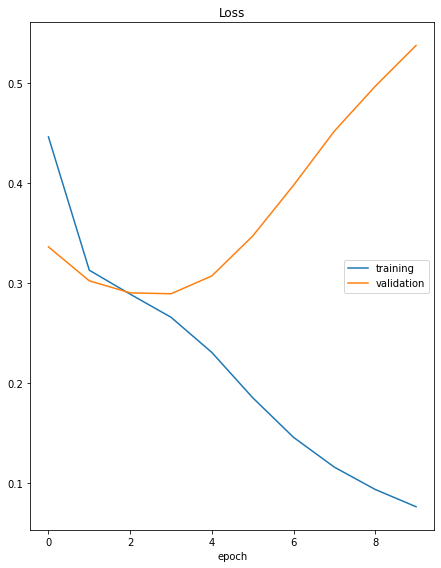

Loss
	training         	 (min:    0.076, max:    0.446, cur:    0.076)
	validation       	 (min:    0.289, max:    0.537, cur:    0.537)


In [78]:
# Fit method
nn_recommender = NNRecommender(model_to_use="NeuMFModel")
nn_recommender.fit(interactions_df, None, None)

In [79]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,67,1.000000,OffSeason,[4-7],Nonref,[0-160],[2-2],True
1,1,577,1.000000,WinterVacation,[0-1],Standard,[0-160],[3-4],False
2,1,446,1.000000,HighSeason,[2-3],Standard,[160-260],[3-4],True
3,1,69,1.000000,OffSeason,[2-3],Nonref,[160-260],[5-inf],True
4,1,23,1.000000,OffSeason,[4-7],Standard,[0-160],[2-2],True
5,1,470,1.000000,HighSeason,[2-3],Nonref,[260-360],[5-inf],True
6,1,480,1.000000,HighSeason,[4-7],Nonref,[160-260],[2-2],False
7,1,62,1.000000,OffSeason,[4-7],Standard,[160-260],[2-2],True
8,1,617,1.000000,WinterVacation,[2-3],Nonref,[0-160],[3-4],True
9,1,526,1.000000,LowSeason,[0-1],Standard,[0-160],[2-2],False


# Tuning method

In [26]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [27]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

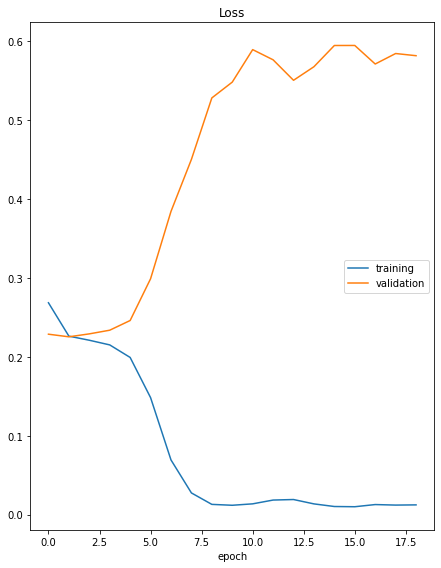

Loss
	training         	 (min:    0.010, max:    0.268, cur:    0.012)
	validation       	 (min:    0.225, max:    0.594, cur:    0.581)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.035135,0.088514,0.125,0.180405,0.035135,0.066248,0.081354,0.099145


Best parameters:
{'batch_size': 96.0, 'embedding_dim': 102.0, 'lr': 0.0009000000000000001, 'model_to_use': 0, 'n_epochs': 19.0, 'n_neg_per_pos': 10.0, 'optimizer_to_use': 1, 'weight_decay': 0.00095}


In [81]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 15, 1),
    'n_epochs': hp.quniform('n_epochs', 5, 30, 1),
    'lr': hp.quniform('lr', 0.0005, 0.01, 0.0001),
    'embedding_dim': hp.quniform('embedding_dim', 4, 128, 2),
    'batch_size': hp.quniform('batch_size', 16, 128, 8),
    'weight_decay': hp.quniform('weight_decay', 0.00001, 0.001, 0.00005),
    'model_to_use': hp.choice('model_to_use', ['GMFModel', 'MLPModel', 'NeuMFModel']),
    'optimizer_to_use': hp.choice('optimizer_to_use', ['SGD', 'Adam'])
    
}
best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=60, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

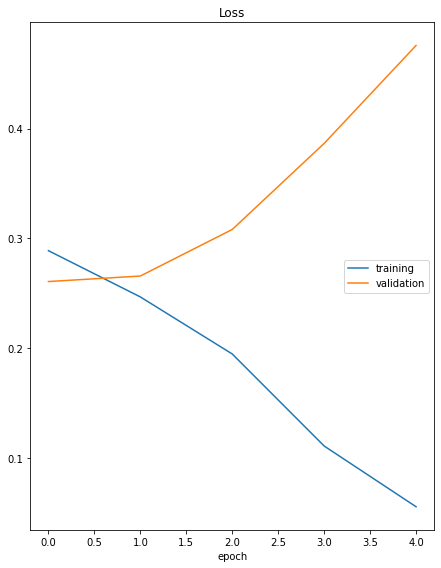

Loss
	training         	 (min:    0.055, max:    0.289, cur:    0.055)
	validation       	 (min:    0.261, max:    0.476, cur:    0.476)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.033108,0.085811,0.121622,0.175676,0.033108,0.063839,0.078625,0.095986


Best parameters:
{'batch_size': 56.0, 'embedding_dim': 32.0, 'lr': 0.0054, 'model_to_use': 0, 'n_epochs': 5.0, 'n_neg_per_pos': 8.0, 'optimizer_to_use': 1, 'weight_decay': 5e-05}


In [80]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 3, 10, 1),
    'n_epochs': hp.quniform('n_epochs', 5, 20, 1),
    'lr': hp.quniform('lr', 0.0005, 0.01, 0.0002),
    'embedding_dim': hp.quniform('embedding_dim', 4, 52, 2),
    'batch_size': hp.quniform('batch_size', 16, 128, 8),
    'weight_decay': hp.quniform('weight_decay', 0.00001, 0.001, 0.00005),
    'model_to_use': hp.choice('model_to_use', ['NeuMFModel']),
    'optimizer_to_use': hp.choice('optimizer_to_use', ['SGD', 'Adam'])
    
}
best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=30, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

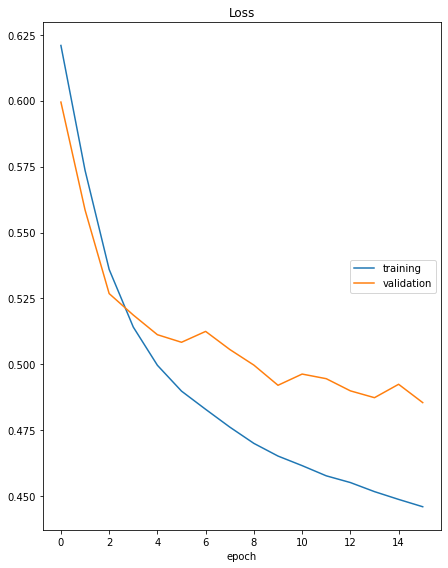

Loss
	training         	 (min:    0.446, max:    0.621, cur:    0.446)
	validation       	 (min:    0.486, max:    0.599, cur:    0.486)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderMLPModelSGD,0.035811,0.091892,0.130068,0.187838,0.035811,0.068584,0.084374,0.103034


In [70]:
nn_recommender1 = NNRecommender(
    batch_size = 32,
    embedding_dim = 22,
    lr = 0.0063,
    model_to_use = 'MLPModel',
    n_epochs = 16,
    n_neg_per_pos = 2,
    optimizer_to_use = 'SGD',
    weight_decay = 0.00085
)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results1 = [['BasicRecommenderMLPModelSGD'] + list(evaluate_train_test_split_implicit(
    nn_recommender1, interactions_df, items_df))]

nn_tts_results1 = pd.DataFrame(
    nn_tts_results1, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results1.to_html()))

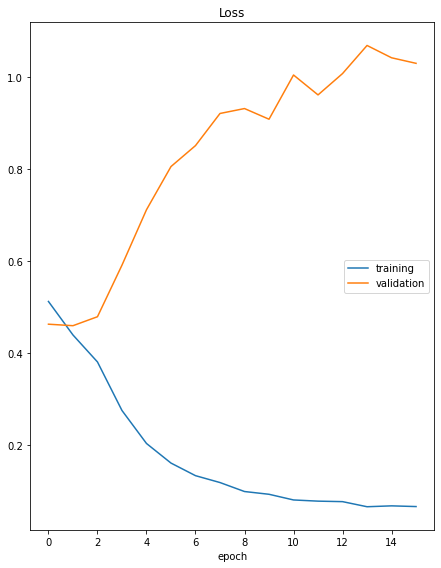

Loss
	training         	 (min:    0.065, max:    0.512, cur:    0.066)
	validation       	 (min:    0.459, max:    1.069, cur:    1.030)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderMLPModelAdam,0.033784,0.085473,0.122635,0.177703,0.033784,0.063831,0.079154,0.09685


In [65]:
nn_recommender2 = NNRecommender(
    batch_size = 32,
    embedding_dim = 22,
    lr = 0.0063,
    model_to_use = 'MLPModel',
    n_epochs = 16,
    n_neg_per_pos = 2,
    optimizer_to_use = 'Adam',
    weight_decay = 0.00085
)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results2 = [['BasicRecommenderMLPModelAdam'] + list(evaluate_train_test_split_implicit(
    nn_recommender2, interactions_df, items_df))]

nn_tts_results2 = pd.DataFrame(
    nn_tts_results2, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results2.to_html()))

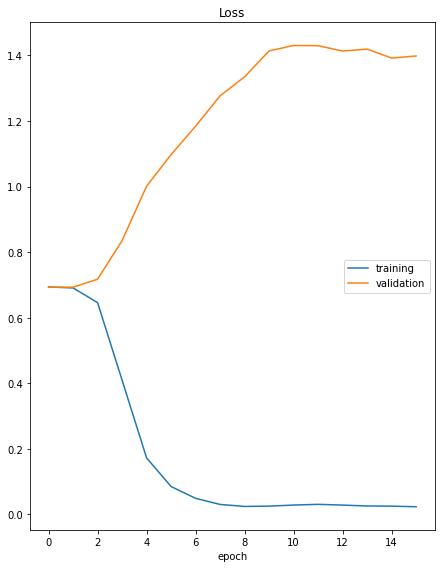

Loss
	training         	 (min:    0.024, max:    0.694, cur:    0.024)
	validation       	 (min:    0.693, max:    1.430, cur:    1.398)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderGMFModelAdam,0.034122,0.086486,0.123986,0.180405,0.034122,0.064772,0.080285,0.098471


In [66]:
nn_recommender3 = NNRecommender(
    batch_size = 32,
    embedding_dim = 22,
    lr = 0.0063,
    model_to_use = 'GMFModel',
    n_epochs = 16,
    n_neg_per_pos = 2,
    optimizer_to_use = 'Adam',
    weight_decay = 0.00085
)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results3 = [['BasicRecommenderGMFModelAdam'] + list(evaluate_train_test_split_implicit(
    nn_recommender3, interactions_df, items_df))]

nn_tts_results3 = pd.DataFrame(
    nn_tts_results3, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results3.to_html()))

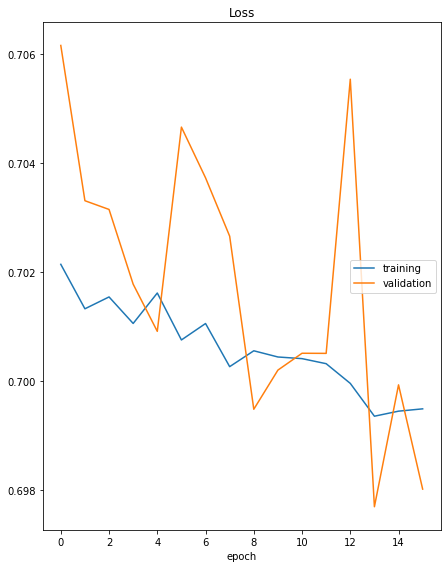

Loss
	training         	 (min:    0.699, max:    0.702, cur:    0.699)
	validation       	 (min:    0.698, max:    0.706, cur:    0.698)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderGMFModelSGD,0.031081,0.07973,0.113176,0.161824,0.031081,0.059431,0.073272,0.088982


In [67]:
nn_recommender4 = NNRecommender(
    batch_size = 32,
    embedding_dim = 22,
    lr = 0.0063,
    model_to_use = 'GMFModel',
    n_epochs = 16,
    n_neg_per_pos = 2,
    optimizer_to_use = 'SGD',
    weight_decay = 0.00085
)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results4 = [['BasicRecommenderGMFModelSGD'] + list(evaluate_train_test_split_implicit(
    nn_recommender4, interactions_df, items_df))]

nn_tts_results4 = pd.DataFrame(
    nn_tts_results4, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results4.to_html()))

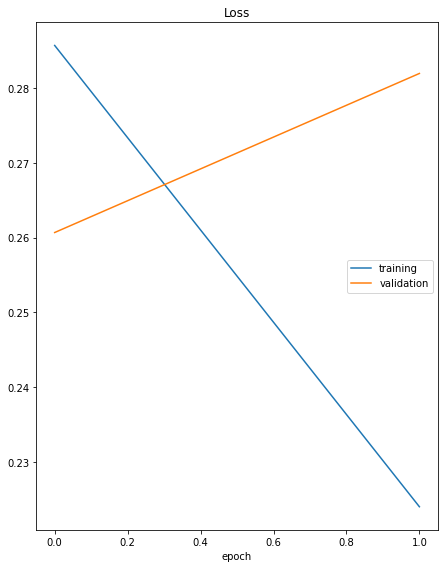

Loss
	training         	 (min:    0.224, max:    0.286, cur:    0.224)
	validation       	 (min:    0.261, max:    0.282, cur:    0.282)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderNeuMFModelAdam,0.036824,0.090541,0.129054,0.184797,0.036824,0.068017,0.083864,0.101793


In [85]:
nn_recommender5 = NNRecommender(
    batch_size = 56,
    embedding_dim = 32,
    lr = 0.0054,
    model_to_use = 'NeuMFModel',
    n_epochs = 2,
    n_neg_per_pos = 8,
    optimizer_to_use = 'Adam',
    weight_decay = 0.00005
)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results5 = [['BasicRecommenderNeuMFModelAdam'] + list(evaluate_train_test_split_implicit(
    nn_recommender5, interactions_df, items_df))]

nn_tts_results5 = pd.DataFrame(
    nn_tts_results5, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results5.to_html()))

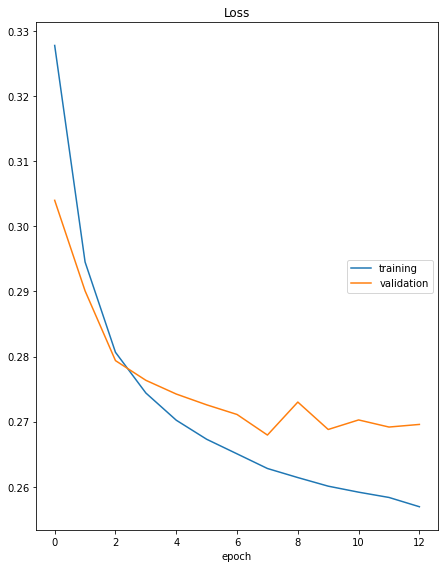

Loss
	training         	 (min:    0.257, max:    0.328, cur:    0.257)
	validation       	 (min:    0.268, max:    0.304, cur:    0.270)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderNeuMFModelSGD,0.034797,0.090203,0.127703,0.182432,0.034797,0.066968,0.082481,0.10008


In [88]:
nn_recommender6 = NNRecommender(
    batch_size = 56,
    embedding_dim = 32,
    lr = 0.0054,
    model_to_use = 'NeuMFModel',
    n_epochs = 13,
    n_neg_per_pos = 8,
    optimizer_to_use = 'SGD',
    weight_decay = 0.00005
)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results6 = [['BasicRecommenderNeuMFModelSGD'] + list(evaluate_train_test_split_implicit(
    nn_recommender6, interactions_df, items_df))]

nn_tts_results6 = pd.DataFrame(
    nn_tts_results6, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results6.to_html()))

In [51]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.031081,0.080068,0.113514,0.165203,0.031081,0.059644,0.073486,0.090119


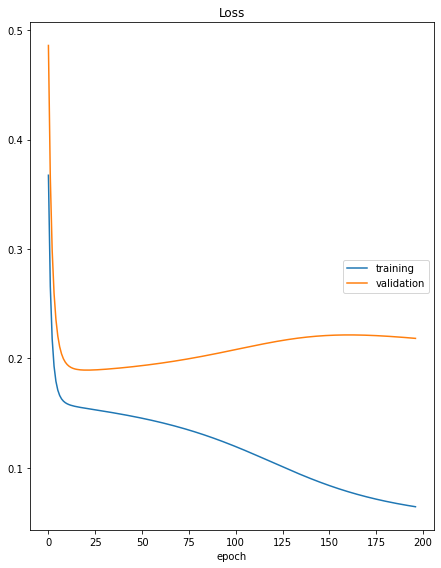

Loss
	training         	 (min:    0.064, max:    0.367, cur:    0.064)
	validation       	 (min:    0.189, max:    0.486, cur:    0.218)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.03277,0.084122,0.119257,0.173311,0.03277,0.062737,0.077276,0.09463


In [52]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [89]:
tts_results = pd.concat([
    nn_tts_results1,
    nn_tts_results2, 
    nn_tts_results3, 
    nn_tts_results4,
    nn_tts_results5,
    nn_tts_results6,
    amazon_tts_results, 
    netflix_tts_results
]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,BasicRecommenderMLPModelSGD,0.035811,0.091892,0.130068,0.187838,0.035811,0.068584,0.084374,0.103034
1,BasicRecommenderMLPModelAdam,0.033784,0.085473,0.122635,0.177703,0.033784,0.063831,0.079154,0.096850
2,BasicRecommenderGMFModelAdam,0.034122,0.086486,0.123986,0.180405,0.034122,0.064772,0.080285,0.098471
3,BasicRecommenderGMFModelSGD,0.031081,0.079730,0.113176,0.161824,0.031081,0.059431,0.073272,0.088982
4,BasicRecommenderNeuMFModelAdam,0.036824,0.090541,0.129054,0.184797,0.036824,0.068017,0.083864,0.101793
5,BasicRecommenderNeuMFModelSGD,0.034797,0.090203,0.127703,0.182432,0.034797,0.066968,0.082481,0.100080
6,AmazonRecommender,0.031081,0.080068,0.113514,0.165203,0.031081,0.059644,0.073486,0.090119
7,NetflixRecommender,0.032770,0.084122,0.119257,0.173311,0.032770,0.062737,0.077276,0.094630


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

n_neg_per_pos=5, embedding_dim=4, batch_size=64 -> terrible results, after 30 epochs loss for validation
data set > 1.4, loss for training data set > 0.6

 	Recommender 	HR@1 	HR@3 	HR@5 	HR@10 	NDCG@1 	NDCG@3 	NDCG@5 	NDCG@10
0 	NNRecommender 	0.034122 	0.088176 	0.126014 	0.181419 	0.034122 	0.065483 	0.081158 	0.099128

Best parameters:
{'batch_size': 32.0, 'embedding_dim': 22.0, 'lr': 0.0063, 'model_to_use': 1, 'n_epochs': 5.0, 'n_neg_per_pos': 2.0, 'optimizer_to_use': 0, 'weight_decay': 0.0008500000000000001}
